# Sentinel Hub Process API

In this example notebook we show how to use Sentinel Hub Process API to download satellite imagery. We describe how to use various parameters and configurations to obtain either processed products or raw band data. For more information about the service please check the [official service documentation](https://docs.sentinel-hub.com/api/latest/api/process/).

## Prerequisites

### Credentials

Process API requires Sentinel Hub account. Please check [configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html) about how to set up your Sentinel Hub credentials.

In [1]:
from sentinelhub import SHConfig

config = SHConfig(
    instance_id='8b5b5797-c269-42a4-b75a-dc1ed7e469a8',
    sh_client_id='f00771eb-624d-4106-973a-98963b395356',
sh_client_secret = 'vnUy3ozu_s[z}W1O/>l6%U6GsfLfs]tLeS@jBs%!',
    sh_base_url='https://services.sentinel-hub.com',
 )
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

c:\Users\tmand\.virtualenvs\AgroLuege-2VDmF-75\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###  Imports 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    ResamplingType
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

### Setting area of interest

We will download Sentinel-2 imagery of [Betsiboka Estuary](https://en.wikipedia.org/wiki/Betsiboka_River) such as the one shown below (taken by Sentinel-2 on 2017-12-15):

![title](data/wms_TRUE_COLOR_EPSG4326_-16.15_46.16_-15.58_46.51_2017-12-15T07-12-03_512X856.png)

The bounding box in `WGS84` coordinate system is `[46.16, -16.15, 46.51, -15.58]` (longitude and latitude coordinates of lower left and upper right corners). You can get the bbox for a different area at the [bboxfinder](http://bboxfinder.com/) website.

All requests require bounding box to be given as an instance of `sentinelhub.geometry.BBox` with corresponding Coordinate Reference System (`sentinelhub.constants.CRS`). In our case it is in _WGS84_ and we can use the predefined _WGS84_ coordinate reference system from `sentinelhub.constants.CRS`.

In [5]:
betsiboka_coords_wgs84 = (7.438632, 46.951082877, 7.758410936, 47.175486984)
# 7.676219, 46.812455, 7.681600, 46.814992
betsiboka_coords_wgs84 = (7.676219, 46.812455, 7.681600, 46.814992)

When the bounding box bounds have been defined, you can initialize the `BBox` of the area of interest. Using the `bbox_to_dimensions` utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape.

In [6]:
resolution = 10
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {betsiboka_size} pixels")

Image shape at 10 m resolution: (42, 28) pixels


## Example 1: True color (PNG) on a specific date

We build the request according to the [API Reference](https://docs.sentinel-hub.com/api/latest/reference/), using the `SentinelHubRequest` class. Each Process API request also needs an [evalscript](https://docs.sentinel-hub.com/api/latest/#/Evalscript/V3/README).


The information that we specify in the `SentinelHubRequest` object is: 

 * an evalscript,
 * a list of input data collections with time interval,
 * a format of the response,
 * a bounding box and it's size (size or resolution).

The evalscript in the example is used to select the appropriate bands. We return the RGB (B04, B03, B02) Sentinel-2 L1C bands.

The image from Jun 12th 2020 is downloaded. Without any additional parameters in the evalscript, the downloaded data will correspond to reflectance values in `UINT8` format (values in 0-255 range).

In [7]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=("2020-01-01", "2020-01-31"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
            # downsampling=ResamplingType.BILINEAR
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

In [8]:
true_color_imgs = request_true_color.get_data()

The method `get_data()` will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays. 

In [9]:
print(f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.")
print(f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}")

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (28, 42, 3)


Image type: uint8


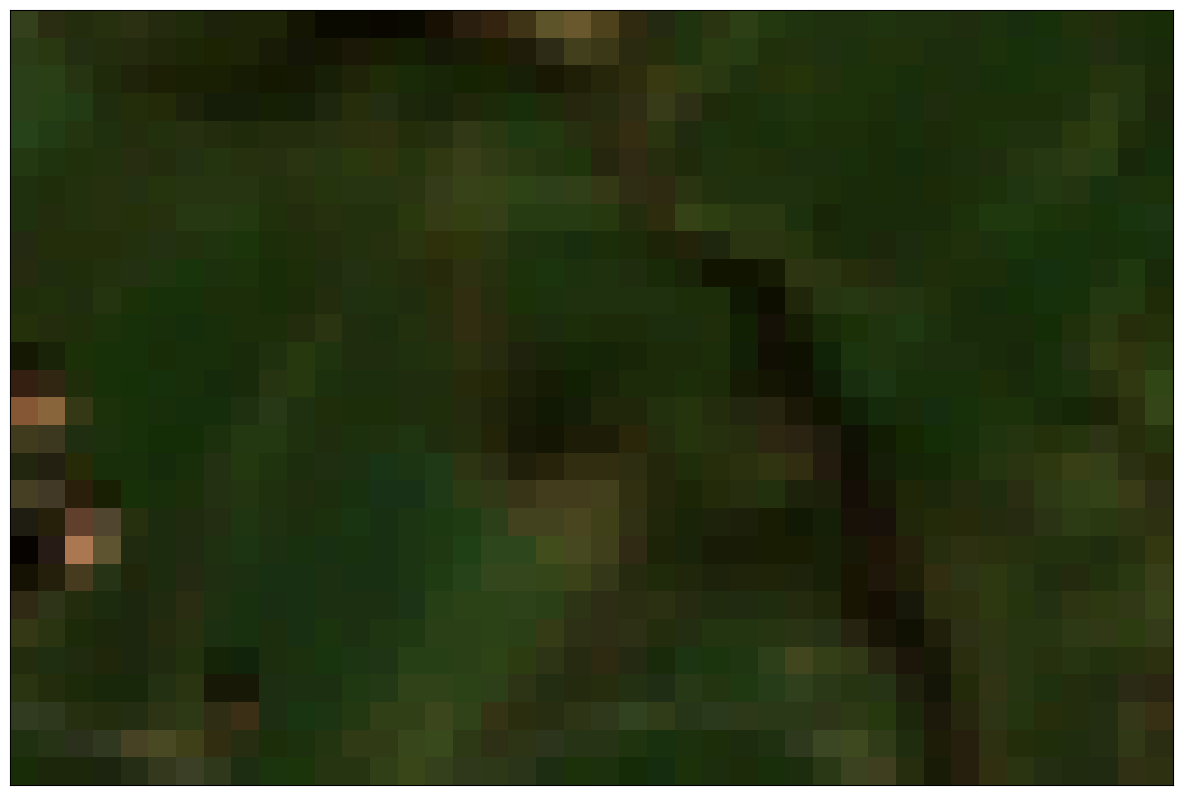

In [10]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

In [57]:
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2020, 12, 31)
n_chunks = 71
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

def get_true_color_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=betsiboka_bbox,
        size=betsiboka_size,
        config=config,
    )

Monthly time windows:

('2020-01-01', '2020-01-06')
('2020-01-06', '2020-01-11')
('2020-01-11', '2020-01-16')
('2020-01-16', '2020-01-21')
('2020-01-21', '2020-01-26')
('2020-01-26', '2020-01-31')
('2020-01-31', '2020-02-05')
('2020-02-05', '2020-02-11')
('2020-02-11', '2020-02-16')
('2020-02-16', '2020-02-21')
('2020-02-21', '2020-02-26')
('2020-02-26', '2020-03-02')
('2020-03-02', '2020-03-07')
('2020-03-07', '2020-03-12')
('2020-03-12', '2020-03-18')
('2020-03-18', '2020-03-23')
('2020-03-23', '2020-03-28')
('2020-03-28', '2020-04-02')
('2020-04-02', '2020-04-07')
('2020-04-07', '2020-04-12')
('2020-04-12', '2020-04-17')
('2020-04-17', '2020-04-23')
('2020-04-23', '2020-04-28')
('2020-04-28', '2020-05-03')
('2020-05-03', '2020-05-08')
('2020-05-08', '2020-05-13')
('2020-05-13', '2020-05-18')
('2020-05-18', '2020-05-23')
('2020-05-23', '2020-05-29')
('2020-05-29', '2020-06-03')
('2020-06-03', '2020-06-08')
('2020-06-08', '2020-06-13')
('2020-06-13', '2020-06-18')
('2020-06-18', '2020

In [58]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

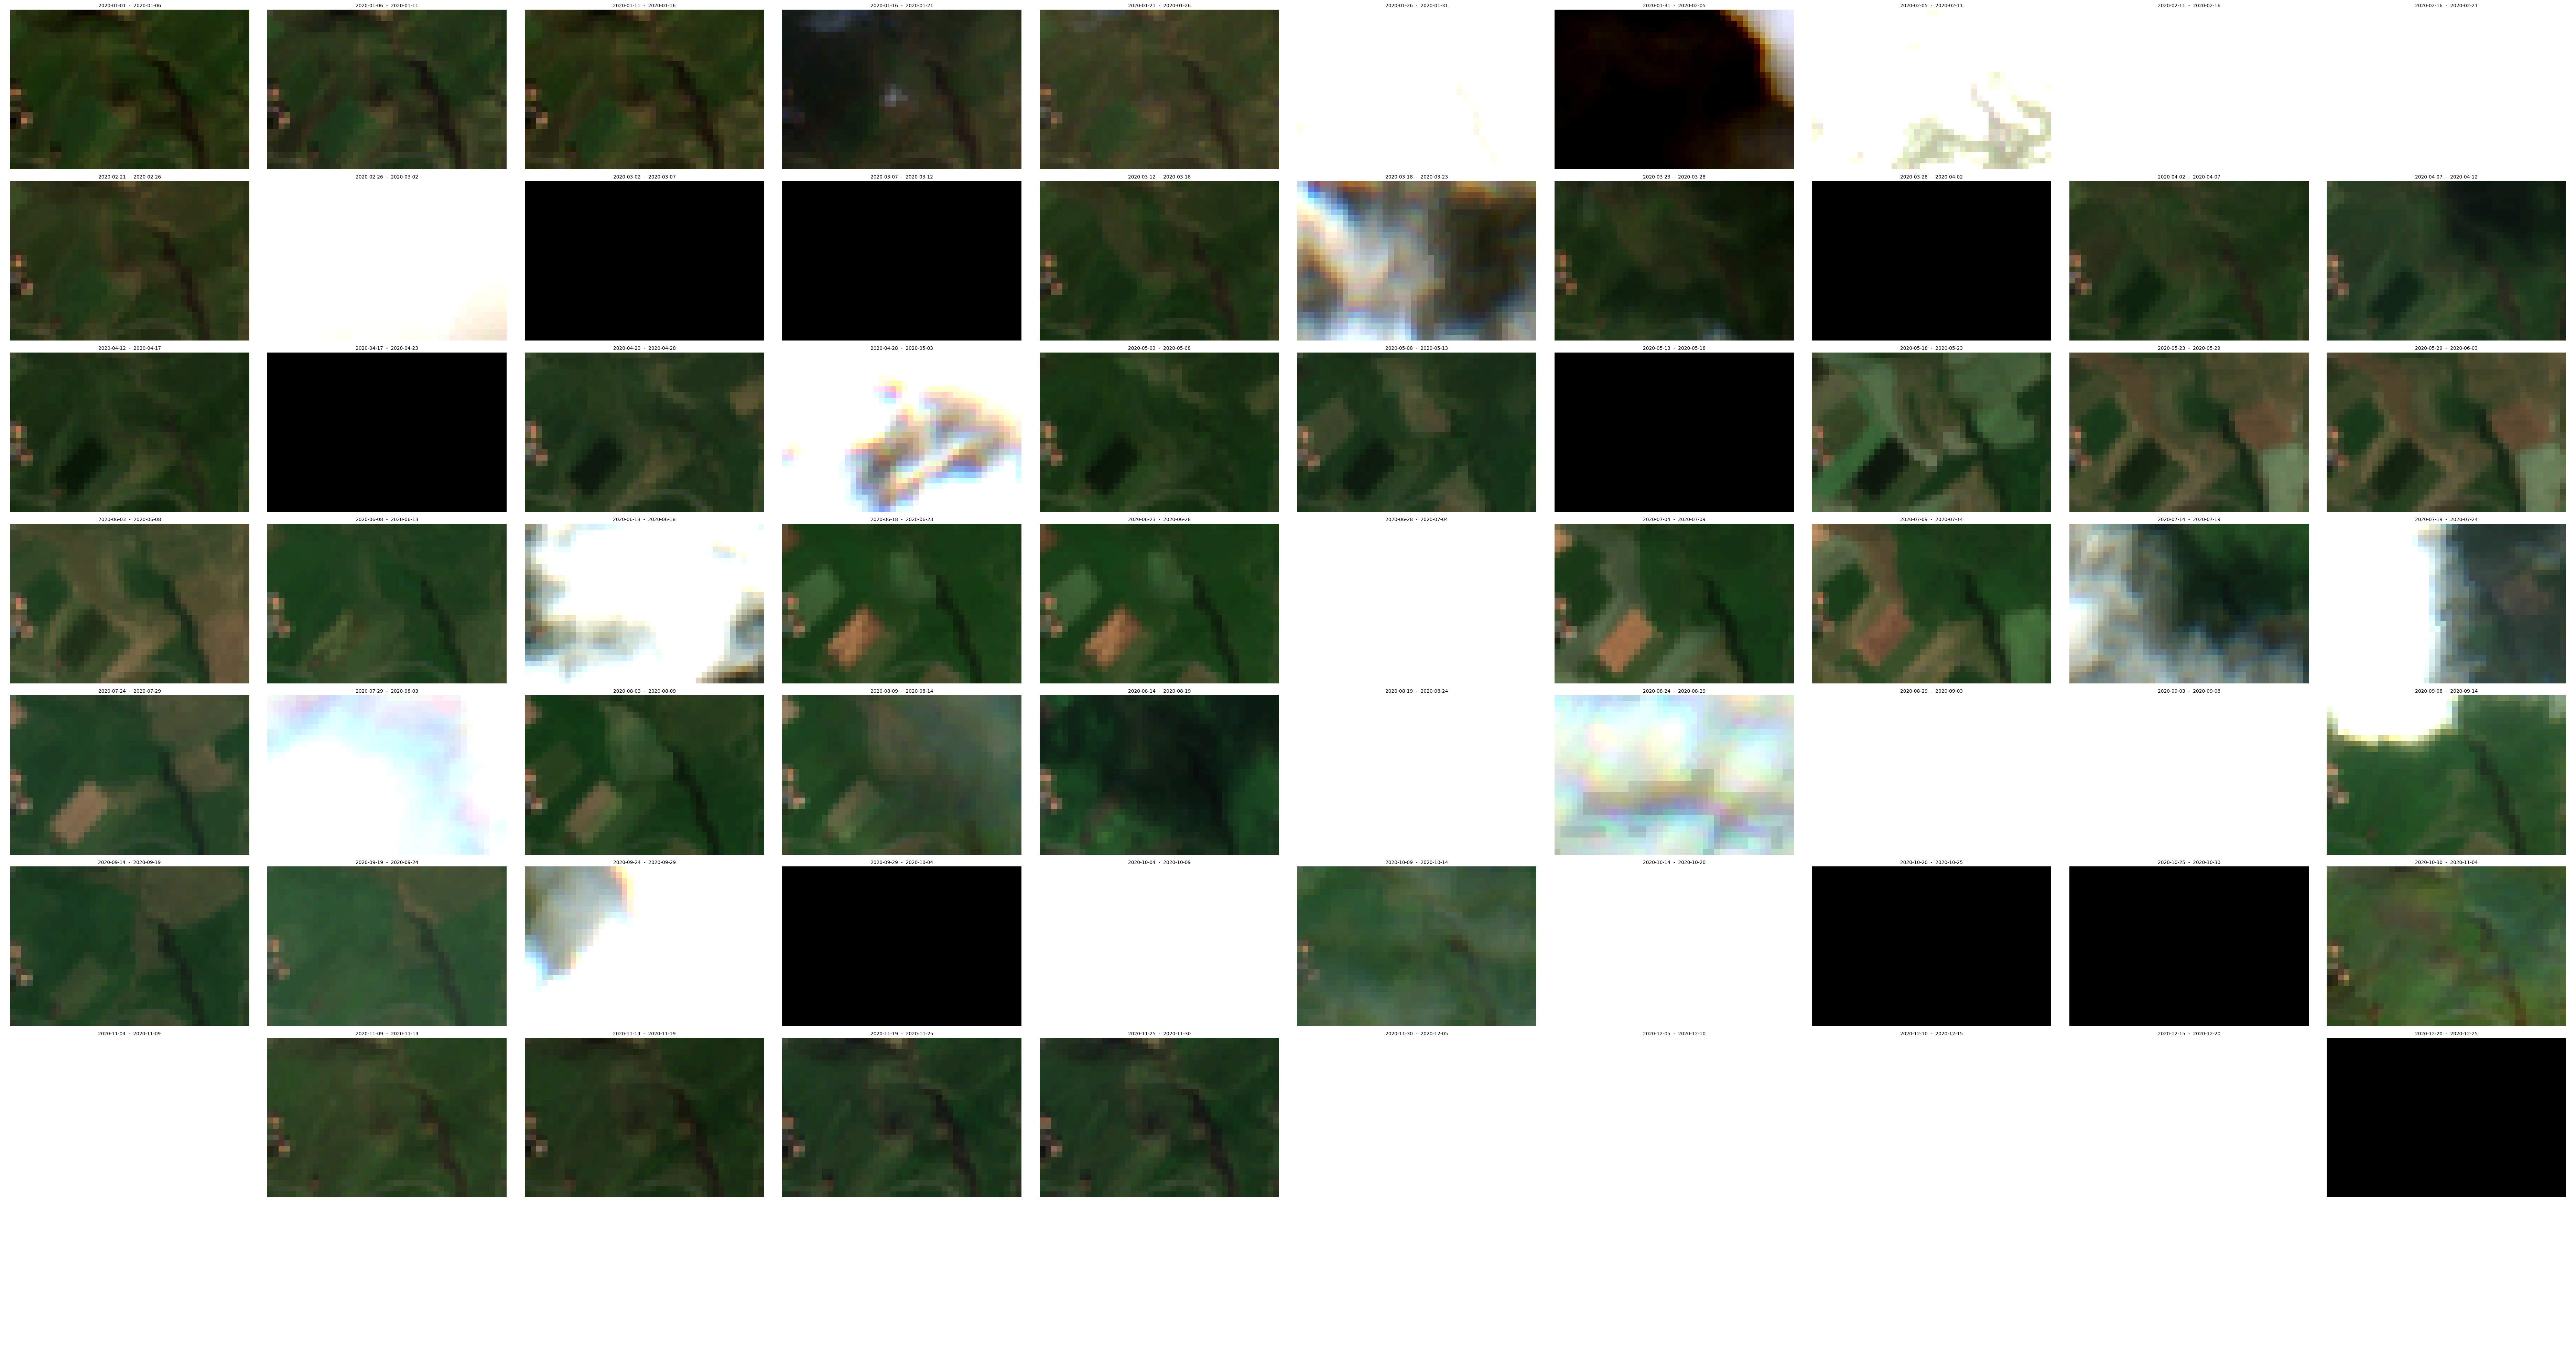

In [60]:
# some stuff for pretty plots
ncols = 10
nrows = 8
aspect_ratio = betsiboka_size[0] / betsiboka_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 3.5 / 255, 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()
